# Task 3
### Firstly, import necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Crypto.Cipher.AES as AES
%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 10]   # size of matplotlib windows

### Declare some global variables like in task 1

In [2]:
# subtitution box for AES-128
Sbox = (0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
        0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
        0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
        0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
        0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
        0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
        0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
        0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
        0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
        0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
        0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
        0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
        0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
        0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
        0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
        0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16)

# array of values of hamming_weight function for bytes from 0 to 255
hamming_weight = [bin(n).count("1") for n in range(0, 256)]

### 2 necessary functions.

In [3]:
def cor(x, y):
    """ Absolute value of Pearson Correlation Coefficient for 2 sets
    
    :param x: numpy array of values
    :param y: numpy array of values
    :return: float number from 0 to 1
    """
    meanX = np.mean(x)             # average values
    meanY = np.mean(y)
    x = x - meanX                  # average differences
    y = y - meanY
    cov = sum(x*y)      
    meanQuadraticX = sum(x ** 2)   # average quadratic differences
    meanQuadraticY = sum(y ** 2)

    res = cov / np.sqrt(meanQuadraticX * meanQuadraticY)   
    return abs(res)


def cross_all_bytes(texts_in, byte_num, n):
    """ Byte search funtion. 
    For each byte from 0 to 255 builds array of leakages for all traces in the context of 
    our math model (attack on the first round)
    
    :param texts_in: numpy array of plaintexts
    :param byte_num: a number of the byte we search
    :return: supposed byte (int number), array of leakages
    """
    for hyp in range(256):
        leak_array = np.zeros(n)
        for _i in range(n):                     
            # leakage is the hamming weight of processed byte
            leak_array[_i] = hamming_weight[Sbox[texts_in[_i][byte_num] ^ hyp]]
        yield hyp, leak_array


### New function for traces shifting 

In [4]:
def sad(x, y):
    """ Sum of absolute differences between 2 arrays.

    :param x: array 1
    :param y: array 2
    :return: array 3
    """
    return sum(abs((x-y)))


### Now we read all the data from input files and plot the first trace.

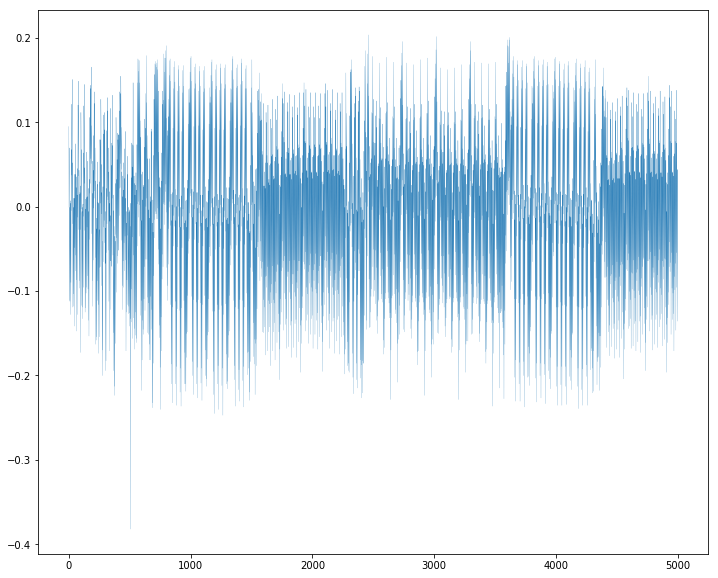

In [5]:
textIn = np.load('textin.npy')      # load the input data
textOut = np.load('textout.npy')
traces = np.load('traces.npy')

traces_amount = len(textIn)
meas_amount = len(traces[0])

plt.plot(traces[0], linewidth=0.2)   # plot the first trace in order to choose the parameters of the window
plt.show()


### Traces shifting

In [6]:
start_window = 800     # parameters of the pattern window that we will search on the other traces
end_window = 1200      # the optimal parameters were chosen by trial and error
len_window = end_window - start_window

start_range = 100      # range on the traces where we will search the pattern
end_range = 4000

diffs = [0, ]          # array with differences along the X-axis for each trace
for trace in traces[1:]:
    diff = 0
    min_sad = 10005000000000         # we search the place on each trace where the SAD is minimum

    for i in range(start_range, end_range):
        if i + len_window > end_range:     # if the window isn't in the chosen range - stop the search
            break
        tmp_sad = sad(traces[0][start_window:end_window], trace[i:i + len_window])
        if tmp_sad < min_sad:
            min_sad = tmp_sad
            diff = i - start_window    # difference along the X-axis between the start of the pattern window and
    diffs.append(diff)                 # start of the place, were we found same window


### Check the correctness of the shifting

1. All the traces on the same section before and after the shifting.

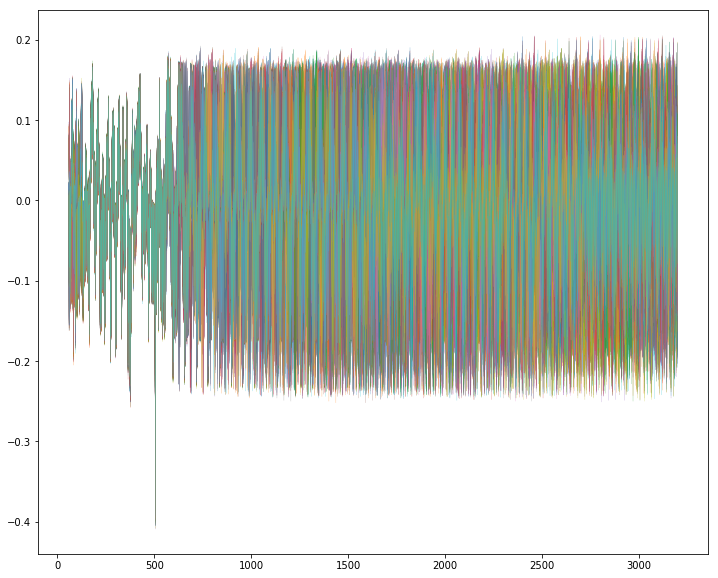

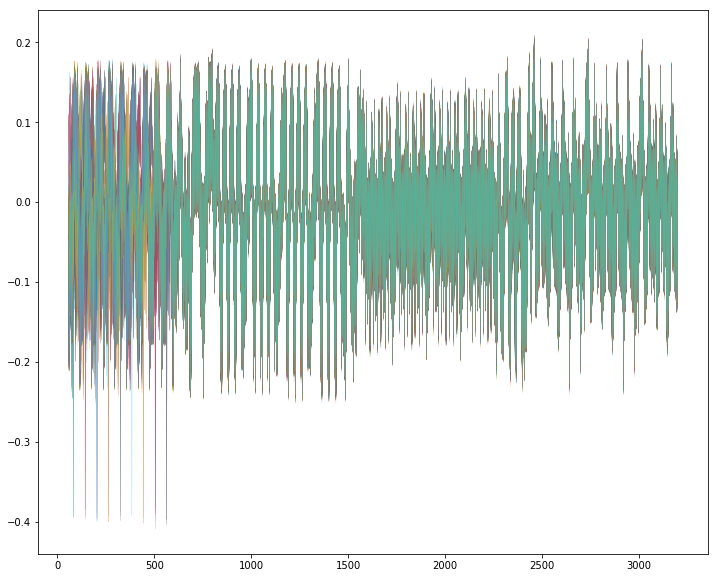

In [11]:
# the range on the traces that there is on each trace
start = abs(min(diffs))
end = meas_amount - max(diffs)

# plot all the traces to illustrate the alignment
for i in range(traces_amount):
    plt.plot(np.arange(start, end), traces[i][start:end], linewidth=0.2)
plt.show()

for i in range(traces_amount):
    plt.plot(np.arange(start, end), traces[i][start+diffs[i]:end+diffs[i]], linewidth=0.2)
plt.show()


2.First 20 traces on the same section but on the different heights.

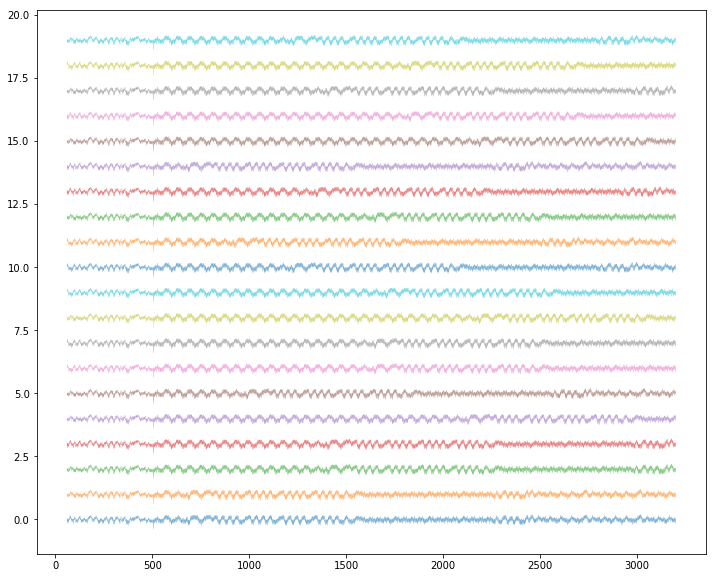

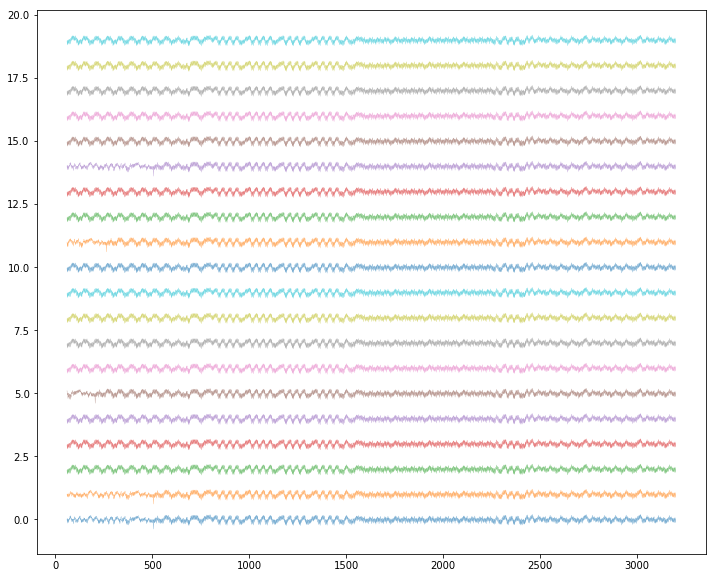

60 3200


In [12]:
for i in range(20):
    plt.plot(np.arange(start, end), traces[i][start:end] + i, linewidth=0.2)
plt.show()

for i in range(20):
    plt.plot(np.arange(start, end), traces[i][start+diffs[i]:end+diffs[i]] + i, linewidth=0.2)
plt.show()
print(start, end)


### The main piece of the program -  key picking.

This part is almost same with such part in task 1 except the traces shifting.

In [8]:
key = []
leak_places = []
for k in range(16):
    max_cor = 0
    best_byte = 0
    leak_place = 0
    for byte, leak in cross_all_bytes(textIn, k, traces_amount):

        for i in range(start, end):
            # every traces must be shifted according to their 'diff' values
            real_values = [traces[j][i+diffs[j]] for j in range(traces_amount)]
            tmp_cor = cor(leak, real_values)
            if tmp_cor > max_cor:
                max_cor = tmp_cor
                best_byte = byte
                leak_place = i
    
    leak_places.append(leak_place)
    key.append(best_byte)
    print('\nbyte number:', k)

    print('best byte:', best_byte)
    print('max correlation:', max_cor)
    print('leak place:', leak_places[-1])

print(key)
print(leak_places)



byte number: 0
best byte: 49
max correlation: 0.8669029078281274
leak place: 1589

byte number: 1
best byte: 105
max correlation: 0.9020132388190436
leak place: 1766

byte number: 2
best byte: 86
max correlation: 0.902793216511422
leak place: 1942

byte number: 3
best byte: 101
max correlation: 0.8701309064717327
leak place: 2118

byte number: 4
best byte: 32
max correlation: 0.8662140240420411
leak place: 1630

byte number: 5
best byte: 89
max correlation: 0.8610838154869568
leak place: 2324

byte number: 6
best byte: 48
max correlation: 0.8934067128452479
leak place: 1982

byte number: 7
best byte: 117
max correlation: 0.8736532243126528
leak place: 2157

byte number: 8
best byte: 124
max correlation: 0.8858784882406369
leak place: 1670

byte number: 9
best byte: 50
max correlation: 0.8703010306189368
leak place: 1846

byte number: 10
best byte: 32
max correlation: 0.8823278089267924
leak place: 2022

byte number: 11
best byte: 68
max correlation: 0.8607262667330403
leak place: 2198

### Results

In [9]:
print('key: ', bytes(key)) 
print('leakage places:', leak_places)


key:  b'1iVe Y0u|2 Dr3@M'
leakage places: [1589, 1766, 1942, 2118, 1630, 2324, 1982, 2157, 1670, 1846, 2022, 2198, 1710, 1886, 2062, 2238]


### Check the correctness of an answer encrypting input text manually

In [10]:
test_cipher = AES.new(bytes(key), AES.MODE_ECB)      # mode for AES - electronic codebook
print('plaintext:', textIn[0])
print('ciphertext in files:       ', bytes(list(textOut[0])))
print('ciphertext using found key:', test_cipher.encrypt(bytes(list(textIn[0]))))

plaintext: [ 56  81  57 222 160  74 188 126 150  63 118 177  54 201  32 100]
ciphertext in files:        b"\x88Hr\xaf'\x1a\x04\xe4\xb2\xfd\x1c\xc2\x1c\x9a\xdf\xad"
ciphertext using found key: b"\x88Hr\xaf'\x1a\x04\xe4\xb2\xfd\x1c\xc2\x1c\x9a\xdf\xad"
